# BBVA 

Los saldos diarios (al inicio y cierre) de los cajeros. Estos saldos se registran por un periodo de 5 meses, del 20 de Febrero al 30 de Julio de 2023

 El conjunto de datos incluye el monto en cada cajero en tres o cuatro distintos caseteros (de acuerdo a denominación
de billetes)



Que oportunidades de negocio se pueden encontrar
* Reducir los costos relacionados con la gestión de efectivo
*  obtener predicciones precisas sobre las necesidades de efectivo, de modo que podamos abastecer óptimamente de las ATM’s
* oportunidades de negocio al minimizar el efectivo improductivo y el
costo de transporte de efectivo

# Objetivos
- Predecir el monto de efectivo que paga un cajero de forma diaria
- Generar un reporte ejecutivo sin predicciones (dashboard)

# Limpieza de datos

In [1]:
# Dependencias para la lectura de datos
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_parquet("C:/Users/oscar/Downloads/BBVA/test.parquet")
train = pd.read_parquet("C:/Users/oscar/Downloads/BBVA/train.parquet")

In [3]:
def Clean_process_data(data):
    # quitamos los espacios en blanco
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    # quitar los salgos inicales donde hay 0 y no hay valores en las otras columnas 
    # Habian MMM y otros pero entran ene sta categoria si no, tendriamos que hacer un analisis mas profundo
    data = data[~((data['SALDOINICIAL'] == 0) & (data[['SALDOFINAL', 'CONCENTRADO', 'DOTADO', 'PAGADO']].eq(0).all(axis=1)))]

    # Renombrar denominacion del billete
    data.iloc[:, data.columns.get_loc('DENOMINACION')] = data['DENOMINACION'].replace({
    'MXPB0000000100': 100,
    'MXPB0000000200': 200,
    'MXPB0000000500': 500,
    'MXPB0000000020': 20,
    'MXPB0000000050': 50,
    'MXPB0000001000': 1000
    })

    # Podemos borrarlas por que X solo son 0 y todas las fechas son iguales entonces solo nos quedaremos con uina 
    data = data.drop(columns = ['X','FECHA-CIERRE-LOAD','FECHA-CIERRE-CUTOFF'])

    return data

In [4]:
def calculate_SF(data):
    data['SALDOFINAL'] = (data['SALDOINICIAL'] + data['DOTADO'] - data['PAGADO'] - data['CONCENTRADO']).abs()
    return data

In [5]:
def time_features(data):
    data['FECHA'] = pd.to_datetime(data['FECHA'])
    data['MES'] = data['FECHA'].dt.month
    data['DIA_SEMANA'] = data['FECHA'].dt.dayofweek
    data['SEMANA'] = data['FECHA'].dt.isocalendar().week
    return data

In [6]:
# Usamos la función para limpiar los datos y reasignar el DataFrame
df = Clean_process_data(df)
df = calculate_SF(df)
df = time_features(df)

In [7]:
5420000 - 0 - 0 + 5520000

10940000

In [8]:
df['PAGADO_CHECK'] = (df['SALDOINICIAL'] - df['SALDOFINAL'] - df['CONCENTRADO'] + df['DOTADO']).abs()

In [9]:
5420000 - 200000 - 5520000 + 0

-300000

In [10]:
df

,ATM_ID,FECHA,DENOMINACION,SALDOINICIAL,SALDOFINAL,CONCENTRADO,DOTADO,PAGADO,MES,DIA_SEMANA,SEMANA,PAGADO_CHECK
3,MM0002,2023-02-20,100,6180000,7960000,0,4030000,2250000,2,0,8,2250000
4,MM0002,2023-02-20,200,17560000,19460000,0,6000000,4100000,2,0,8,4100000
5,MM0002,2023-02-20,500,14000000,29150000,0,42000000,26850000,2,0,8,26850000
9,MM0004,2023-02-20,100,9650000,8540000,0,0,1110000,2,0,8,1110000
10,MM0004,2023-02-20,200,19260000,16880000,0,0,2380000,2,0,8,2380000
...,...,...,...,...,...,...,...,...,...,...,...,...
6036734,MME998,2023-06-21,500,62850000,51250000,58400000,58400000,11600000,6,2,25,11600000
6036735,MME999,2023-06-21,20,850000,846000,850000,850000,4000,6,2,25,4000
6036736,MME999,2023-06-21,100,4320000,6010000,4080000,6080000,310000,6,2,25,310000
6036737,MME999,2023-06-21,200,8000000,13460000,7580000,13620000,580000,6,2,25,580000


# Expliación de los datos

* ATM_ID: Identificador único de cajero

* Fecha: Fecha de la transacción (DIARIA)

* DENOMINACION: BILLETE 

* SALDO_INICIAL: Saldo inicial del cajero CAMBIA CONFORME AL TIEMPO Y SI SACAN DINERO ETC

* SALDO_FINAL: Saldo final del cajero al final del día

* MONTO: Monto de efectivo pagado por el cajero en el día

* Dotado: Cantidad de dinero cargada en el cajero automático en un período específico. Es la cantidad de efectivo que se coloca en el cajero para asegurar que tenga suficiente dinero para satisfacer las necesidades de los clientes que realizan retiros.

* Concentrado: Cantidad de dinero que la empresa retira del cajero automático para llevarlo a sus bóvedas o centros de efectivo. Esta operación se realiza para recoger el dinero excedente en el cajero, reduciendo así el riesgo de tener grandes cantidades de efectivo en el mismo y gestionando mejor el flujo de efectivo de la empresa.

* Pagado: Cantidad de dinero que ha sido retirada del cajero automático por los clientes en un período específico. Es una variable continua que indica el volumen de efectivo dispensado a los clientes y sirve como el objetivo en muchos análisis predictivos.

# Dashboard 

In [11]:
# aqui el df to 

poner aqui imagen jeje

# Análisis exploratorio de datos (EDA)

In [12]:
# Dependencias para la visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

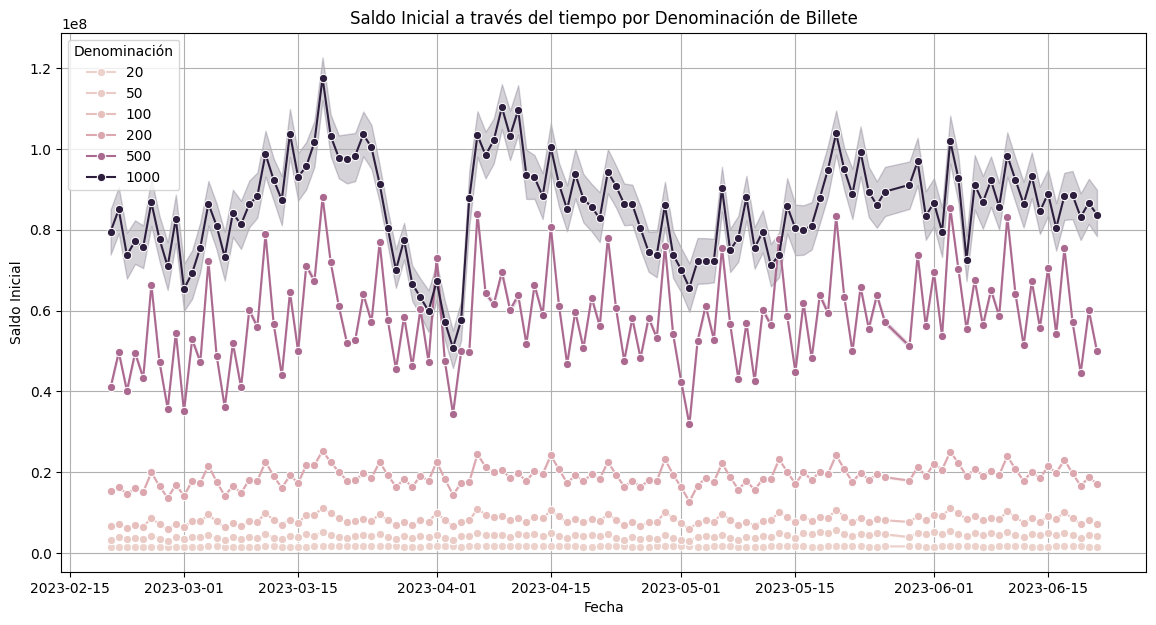

In [12]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='FECHA', y='SALDOINICIAL', hue='DENOMINACION', marker='o')

# Personalizar la gráfica
plt.title('Saldo Inicial a través del tiempo por Denominación de Billete')
plt.xlabel('Fecha')
plt.ylabel('Saldo Inicial')
plt.legend(title='Denominación')
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [13]:
# Agrupar por semana y denominación
grouped_weekly = df.groupby(['SEMANA', 'DENOMINACION'])['SALDOINICIAL'].mean().reset_index()
# Agruparpor mes y denominación
grouped_monthly = df.groupby(['MES', 'DENOMINACION'])['SALDOINICIAL'].mean().reset_index()

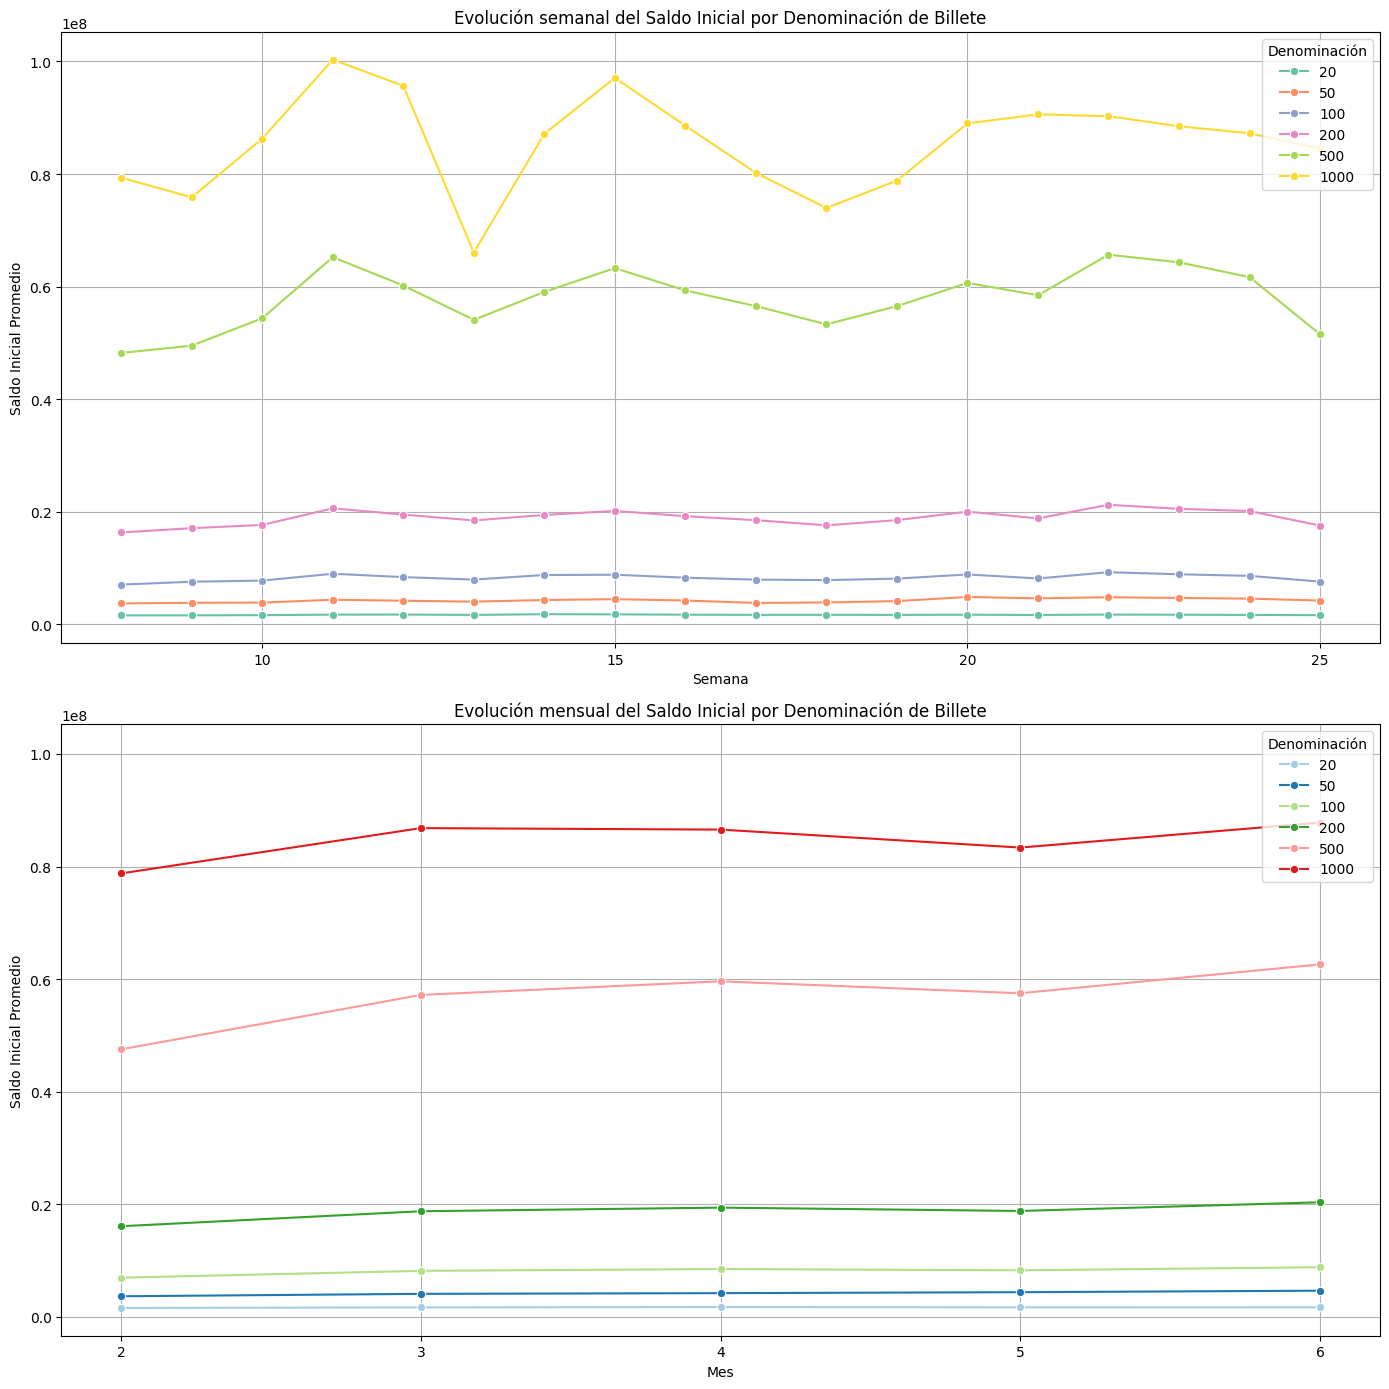

In [14]:
# Crear los subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 14), sharey=True)

# Gráfica de líneas para semanas
sns.lineplot(data=grouped_weekly, x='SEMANA', y='SALDOINICIAL',
                hue='DENOMINACION', marker='o',palette='Set2' ,ax=axes[0])
axes[0].set_title('Evolución semanal del Saldo Inicial por Denominación de Billete')
axes[0].set_xlabel('Semana')
axes[0].set_ylabel('Saldo Inicial Promedio')
axes[0].legend(title='Denominación')
axes[0].grid(True)
axes[0].xaxis.get_major_locator().set_params(integer=True) 

# Gráfica de líneas para meses
sns.lineplot(data=grouped_monthly, x='MES', y='SALDOINICIAL', 
                hue='DENOMINACION', marker='o', palette='Paired', ax=axes[1])
axes[1].set_title('Evolución mensual del Saldo Inicial por Denominación de Billete')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Saldo Inicial Promedio')
axes[1].legend(title='Denominación')
axes[1].grid(True)
axes[1].xaxis.get_major_locator().set_params(integer=True)  # Asegurar etiquetas enteras

plt.tight_layout()
plt.show()

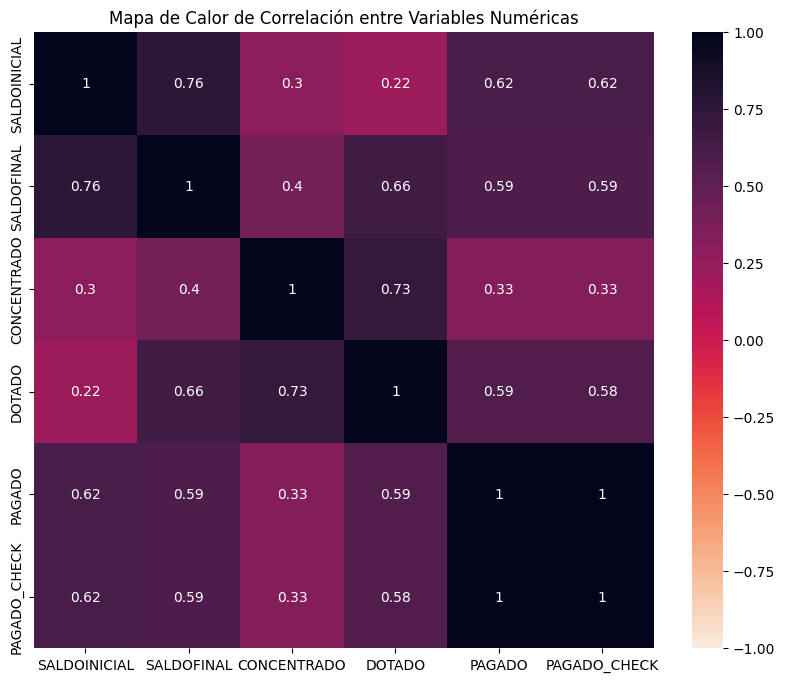

In [15]:
numeric_data = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlación entre Variables Numéricas')
plt.show()

In [16]:
atms_saldo_cero = df[df['SALDOINICIAL'] == 0 ]
# Contar las ocurrencias de saldo inicial igual a 0 por ATM_ID y semana
atms_saldo_cero_count = atms_saldo_cero.groupby(['ATM_ID', 'SEMANA']).size().reset_index(name='count')
# Filtrar las ATM_ID que se agotan más de 3 veces
atms_agotadas_mas_de_n_veces = atms_saldo_cero_count.groupby('ATM_ID').filter(lambda x: len(x) > 16)['ATM_ID'].unique()

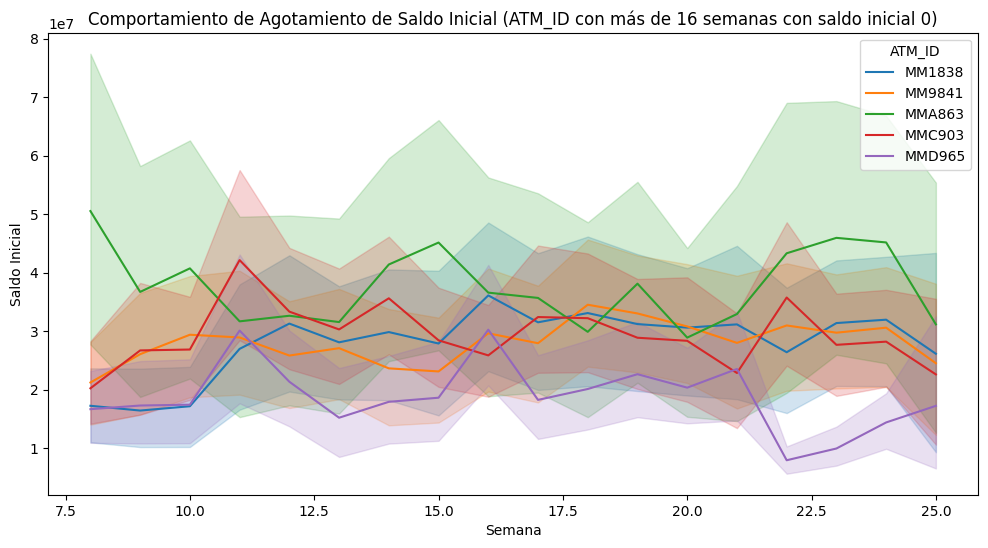

In [17]:
# Filtrar el DataFrame original para las ATM_ID seleccionadas
data_filtrada = df[df['ATM_ID'].isin(atms_agotadas_mas_de_n_veces)]

# Graficar el comportamiento de agotamiento de dinero por semana para las ATM_ID seleccionadas
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_filtrada, x='SEMANA', y='SALDOINICIAL', hue='ATM_ID')
plt.title('Comportamiento de Agotamiento de Saldo Inicial (ATM_ID con más de 16 semanas con saldo inicial 0)')
plt.xlabel('Semana')
plt.ylabel('Saldo Inicial')
plt.legend(title='ATM_ID')
plt.show()

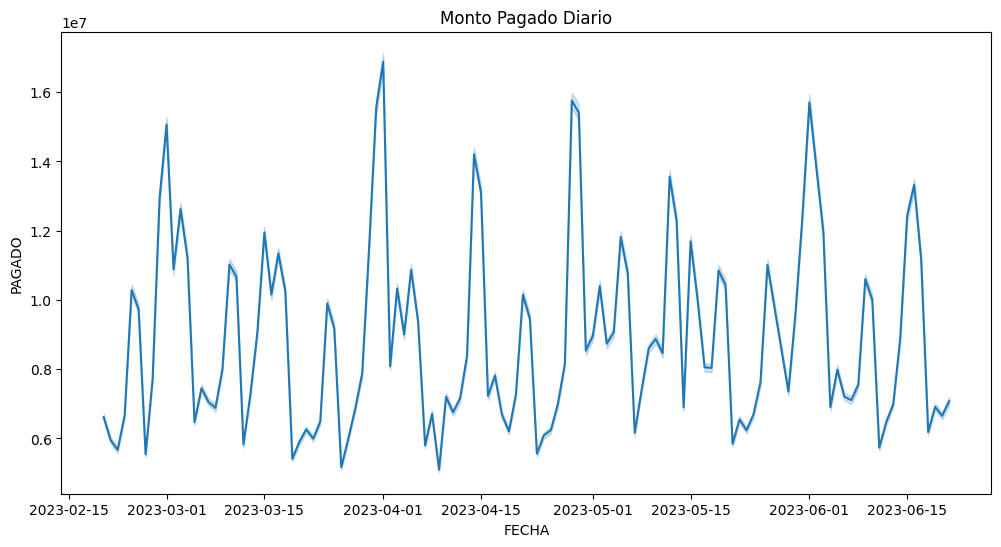

In [71]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='FECHA', y='PAGADO')
plt.title('Monto Pagado Diario')
plt.show()

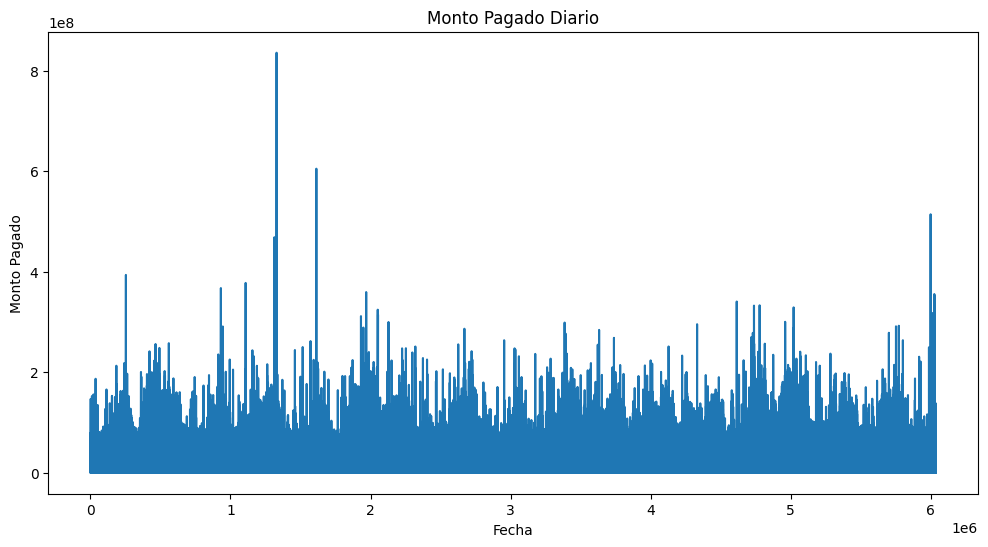

In [18]:
# Visualizar la serie temporal
plt.figure(figsize=(12,6))
plt.plot(df['PAGADO'])
plt.title('Monto Pagado Diario')
plt.xlabel('Fecha')
plt.ylabel('Monto Pagado')
plt.show()

In [13]:
df

,ATM_ID,FECHA,DENOMINACION,SALDOINICIAL,SALDOFINAL,CONCENTRADO,DOTADO,PAGADO,MES,DIA_SEMANA,SEMANA,PAGADO_CHECK
3,MM0002,2023-02-20,100,6180000,7960000,0,4030000,2250000,2,0,8,2250000
4,MM0002,2023-02-20,200,17560000,19460000,0,6000000,4100000,2,0,8,4100000
5,MM0002,2023-02-20,500,14000000,29150000,0,42000000,26850000,2,0,8,26850000
9,MM0004,2023-02-20,100,9650000,8540000,0,0,1110000,2,0,8,1110000
10,MM0004,2023-02-20,200,19260000,16880000,0,0,2380000,2,0,8,2380000
...,...,...,...,...,...,...,...,...,...,...,...,...
6036734,MME998,2023-06-21,500,62850000,51250000,58400000,58400000,11600000,6,2,25,11600000
6036735,MME999,2023-06-21,20,850000,846000,850000,850000,4000,6,2,25,4000
6036736,MME999,2023-06-21,100,4320000,6010000,4080000,6080000,310000,6,2,25,310000
6036737,MME999,2023-06-21,200,8000000,13460000,7580000,13620000,580000,6,2,25,580000


In [15]:
df = df.groupby(['FECHA','ATM_ID'])['PAGADO_CHECK'].sum().reset_index()

In [16]:
df = df.rename(columns={'PAGADO_CHECK': 'PAGADO'})

In [17]:
df = df[df['PAGADO'] <= 2500000]

In [18]:
# Cehcar outliers antes de revisar si es estacionaria 
# Calcular el IQR
Q1 = df['PAGADO'].quantile(0.25)
Q3 = df['PAGADO'].quantile(0.75)
IQR = Q3 - Q1

In [19]:
# Definir límites para identificar outliers (uinfimo y supremo)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [20]:
# Eliminar outliers
df_sin_outliers = df[(df['PAGADO'] >= lower_bound) & (df['PAGADO'] <= upper_bound)]

In [21]:
print(f'Número de outliers eliminados: {df.shape[0] - df_sin_outliers.shape[0]} \n Nuevo tamaño del DataFrame: {df_sin_outliers.shape} \n Tamaño original: {df.shape}') 


Número de outliers eliminados: 0 
 Nuevo tamaño del DataFrame: (158097, 3) 
 Tamaño original: (158097, 3)


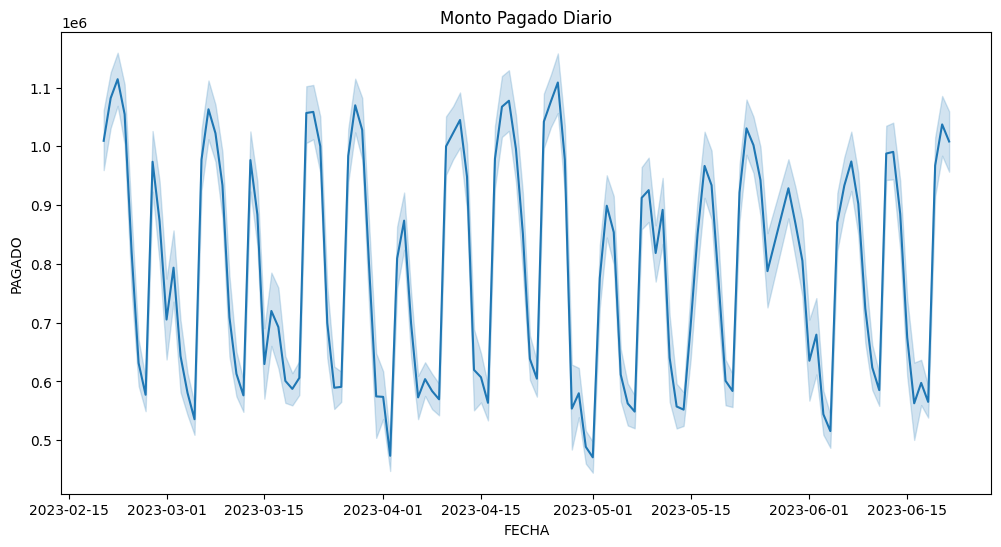

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sin_outliers, x='FECHA', y='PAGADO')
plt.title('Monto Pagado Diario')
plt.show()

<Figure size 1200x600 with 0 Axes>

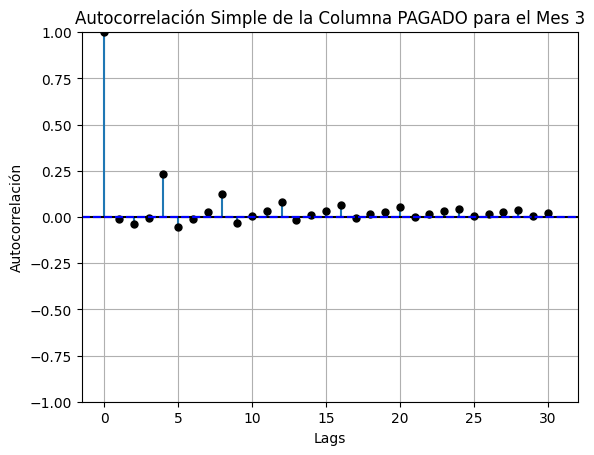

In [30]:
# Filtrar los datos del mes 3
df_mes3 = df_sin_outliers[df_sin_outliers['MES'] == 5]

# Graficar la autocorrelación simple de la columna 'PAGADO' para el mes 3
plt.figure(figsize=(12, 6))
plot_acf(df_mes3['PAGADO'], lags=30, alpha=0.05, color='black')  # Color de la línea de autocorrelación
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación Simple de la Columna PAGADO para el Mes 3')

# Configuración del intervalo de confianza utilizando el número de observaciones
n_obs = len(df_mes3['PAGADO'])
std_err = 1.96 / np.sqrt(n_obs)  # Error estándar para el 95% de confianza

plt.axhline(y=-std_err, linestyle='--', color='blue')  # Límite inferior
plt.axhline(y=std_err, linestyle='--', color='blue')   # Límite superior

plt.grid(True)
plt.ylim(-1, 1)  # Ajustar el rango del eje y para mostrar claramente los valores de autocorrelación
plt.show()

In [24]:
df_modelo

,ATM_ID,FECHA,DENOMINACION,SALDOINICIAL,SALDOFINAL,CONCENTRADO,DOTADO,PAGADO
3,MM0002,2023-02-20,100,6180000,7960000,0,4030000,2250000
9,MM0004,2023-02-20,100,9650000,8540000,0,0,1110000
10,MM0004,2023-02-20,200,19260000,16880000,0,0,2380000
12,MM0005,2023-02-20,100,5550000,5100000,0,0,450000
13,MM0005,2023-02-20,200,11320000,10540000,0,0,780000
...,...,...,...,...,...,...,...,...
6036732,MME998,2023-06-21,100,13230000,12340000,12970000,12970000,890000
6036733,MME998,2023-06-21,200,25780000,23960000,25260000,25260000,1820000
6036735,MME999,2023-06-21,20,850000,846000,850000,850000,4000
6036736,MME999,2023-06-21,100,4320000,6010000,4080000,6080000,310000


# Modelado de datos Series de tiempo

In [33]:
# Predecir el monto de efectivo que paga un cajero de forma diaria
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [37]:
df_modelo = df_sin_outliers.copy()
df_modelo = df_modelo[['ATM_ID', 'FECHA', 'DENOMINACION', 'SALDOINICIAL', 'SALDOFINAL', 'CONCENTRADO', 'DOTADO', 'PAGADO']]

## Estacionariedad de una Serie de Tiempo
La estacionariedad de una serie de tiempo es una propiedad que implica que las propiedades estadísticas de la serie (como la media y la varianza) no cambian con el tiempo. Es decir, una serie es estacionaria si su comportamiento estadístico es constante a lo largo del tiempo


## Importancia de la Estacionariedad
Predicción: Los modelos de series de tiempo, como el ARIMA, asumen que los datos son estacionarios. Si los datos no son estacionarios, el modelo puede producir predicciones inexactas
Modelado: Las series estacionarias facilitan la modelización y el análisis porque sus propiedades no dependen del tiempo, lo que simplifica el proceso

## Prueba de Dickey-Fuller Aumentada (ADF)
La prueba ADF es una de las pruebas más comunes para verificar la estacionariedad de una serie de tiempo. Esta prueba evalúa la hipótesis nula de que una unidad raíz está presente en una muestra de datos (es decir, la serie no es estacionaria)

## Interpretación del p-valor
* p-valor < 0.05: Rechazamos la hipótesis nula. La serie es estacionaria
* p-valor >= 0.05: No podemos rechazar la hipótesis nula. La serie no es estacionaria

## Procedimiento para la Prueba de ADF
Formular la hipótesis:

* Hipótesis nula ($H_0$): La serie tiene una unidad raíz (no es estacionaria)
* Hipótesis alternativa ($H_1$): La serie no tiene una unidad raíz (es estacionaria)

## Calcular el p-valor:
* Si el p-valor es menor que el nivel de significancia (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que la serie es estacionaria
* Si el p-valor es mayor o igual que el nivel de significancia, no podemos rechazar la hipótesis nula y concluimos que la serie no es estacionaria

In [24]:
# Pero antes debemos verificas si la serie es estacionaria, si no el modelo no estaria aprendeiendo nada, solo es recordar 
from statsmodels.tsa.stattools import adfuller

In [74]:
# Tomar una muestra del 10% de los datos ya que me sale error de memoria si uso todos los datos
sample_size = int(0.1 * len(df_modelo))
sample = df_modelo.sample(n=sample_size, random_state=42)

In [75]:
# Función para realizar la prueba ADF y obtener el p-valor
def adf_test(series):
    """
    Realiza la prueba de Dickey-Fuller aumentada y devuelve el p-valor
    """
    result = adfuller(series, autolag='AIC')
    return result[1]  # Retorna el p-valor

# Aplicar la prueba de ADF a la serie 'PAGADO' de la muestra
p_value = adf_test(sample['PAGADO'])
print(f'p-valor: {p_value}')

# Determinar si la serie es estacionaria
if p_value < 0.05:
    print("La serie es estacionaria (rechazamos la hipótesis nula)")
else:
    print("La serie no es estacionaria")

p-valor: 0.0
La serie es estacionaria (rechazamos la hipótesis nula)


Predecir el monto de efectivo que paga un cajero de forma diaria
Desarrollar un modelo de ciencia de datos que permita realizar la 
predicción diaria para cada cajero por un periodo de 2 semanas

                               SARIMAX Results                                
Dep. Variable:                 PAGADO   No. Observations:               988240
Model:                 ARIMA(5, 1, 0)   Log Likelihood           -15124892.359
Date:                Fri, 12 Jul 2024   AIC                       30249796.719
Time:                        00:21:35   BIC                       30249867.541
Sample:                             0   HQIC                      30249816.218
                             - 988240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7971      0.001   -819.568      0.000      -0.799      -0.795
ar.L2         -0.6313      0.001   -519.657      0.000      -0.634      -0.629
ar.L3         -0.4768      0.001   -370.860      0.0

C:\Users\oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Error cuadrático medio (MSE): 1142003102392.534


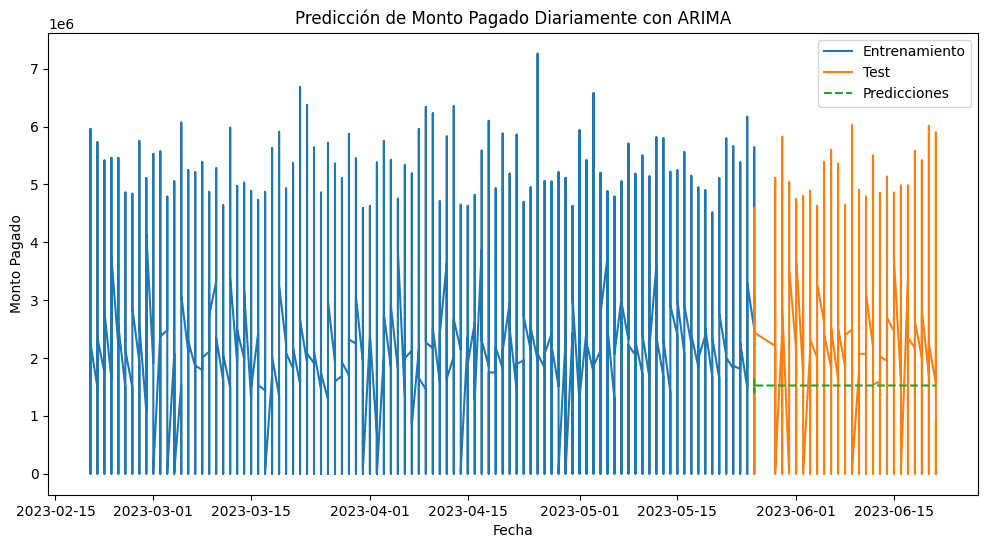

In [22]:
# Agrupar por FECHA y ATM_ID y obtener el total de PAGADO diario por cada cajero automático
data_grouped = df_modelo.groupby(['FECHA', 'ATM_ID'])['PAGADO'].sum().reset_index()

# Dividir los datos en entrenamiento y prueba
train_size = int(len(data_grouped) * 0.8)
train, test = data_grouped.iloc[:train_size], data_grouped.iloc[train_size:]

# Modelo ARIMA
model = ARIMA(train['PAGADO'], order=(5, 1, 0))  # p=1, d=1, q=1
model_fit = model.fit()

# Imprimir el summary del modelo
print(model_fit.summary())

# Predicciones
start_index = len(train)
end_index = len(train) + len(test) - 1
predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')

# Calcular error
error = mean_squared_error(test['PAGADO'], predictions)
print(f'Error cuadrático medio (MSE): {error}')

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(train['FECHA'], train['PAGADO'], label='Entrenamiento')
plt.plot(test['FECHA'], test['PAGADO'], label='Test')
plt.plot(test['FECHA'], predictions, label='Predicciones', linestyle='--')
plt.title('Predicción de Monto Pagado Diariamente con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Monto Pagado')
plt.legend()
plt.show()

In [25]:
df_modelo

,FECHA,ATM_ID,PAGADO
29,2023-02-20,MM0033,2010000
30,2023-02-20,MM0035,135000
36,2023-02-20,MM0041,400000
66,2023-02-20,MM0073,200000
103,2023-02-20,MM0110,1780000
...,...,...,...
1688173,2023-06-21,MME936,0
1688191,2023-06-21,MME956,1302000
1688193,2023-06-21,MME959,2390000
1688213,2023-06-21,MME980,370000


In [29]:
# Ajustar un modelo ARIMA usando auto_arima
auto_model = pm.auto_arima(df_modelo['PAGADO'], 
                           seasonal=False, 
                           stepwise=True, 
                           trace=True)

# Resumen del modelo
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4748675.252, Time=20.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4850213.082, Time=1.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4806843.161, Time=2.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4750673.805, Time=9.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4850211.082, Time=1.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4748735.698, Time=10.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4750600.796, Time=21.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4748674.927, Time=24.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4750599.599, Time=38.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4748673.232, Time=49.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4749571.477, Time=72.05 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4748663.871, Time=68.42 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4749003.534, Time=77.68 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4748196.4